## IDENTFIKASI SERANGAN DDOS RANDOM FOREST

### Import Library

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

### Import Dataset

In [3]:
df = pd.read_csv('dataset_sdn.csv')
df.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [4]:
df.shape

(104345, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [6]:
df.label.unique()

array([0, 1], dtype=int64)

In [7]:

numeric_df = df.select_dtypes(include=['int64', 'float64'])
object_df = df.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns
print('Numeric Columns: ')
print(numeric_cols, '\n')
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Numeric Features: ', len(numeric_cols))
print('Number of Object Features: ', len(object_cols))

Numeric Columns: 
Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label'],
      dtype='object') 

Object Columns: 
Index(['src', 'dst', 'Protocol'], dtype='object') 

Number of Numeric Features:  20
Number of Object Features:  3


In [8]:
object_df.head

<bound method NDFrame.head of               src       dst Protocol
0        10.0.0.1  10.0.0.8      UDP
1        10.0.0.1  10.0.0.8      UDP
2        10.0.0.2  10.0.0.8      UDP
3        10.0.0.2  10.0.0.8      UDP
4        10.0.0.2  10.0.0.8      UDP
...           ...       ...      ...
104340   10.0.0.5  10.0.0.7     ICMP
104341   10.0.0.5  10.0.0.7     ICMP
104342  10.0.0.11  10.0.0.5     ICMP
104343  10.0.0.11  10.0.0.5     ICMP
104344  10.0.0.11  10.0.0.5     ICMP

[104345 rows x 3 columns]>

### *Preprocessing Data*

In [9]:
# Membuang Variabel yang tidak digunakan
to_drop = ['dt']
df = df.drop(to_drop, axis='columns')
df = df[df['pktrate'] !=0]

In [10]:
# Mengubah jenis Tipe data dari masing-masing Variabel yang digunakan
df['src'] = [int(i.split('.')[3]) for i in df['src']]
df['dst'] = [int(i.split('.')[3])for i in df['dst']]
df['switch'] = df['switch'].astype(str) 
df['src'] = df['src'].astype(str)
df['dst'] = df['dst'].astype(str)
df['port_no'] = df['port_no'].astype(str)
df['Protocol'] = df['Protocol'].astype(str)

In [11]:
new_df = pd.get_dummies(df,columns = ['switch','src','Protocol','dst','port_no'])
new_df

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,...,dst_5,dst_6,dst_7,dst_8,dst_9,port_no_1,port_no_2,port_no_3,port_no_4,port_no_5
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,...,0,0,0,1,0,0,0,1,0,0
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,...,0,0,0,1,0,0,0,0,1,0
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,...,0,0,0,1,0,1,0,0,0,0
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,...,0,0,0,1,0,0,1,0,0,0
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104130,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,...,0,0,0,0,0,0,1,0,0,0
104131,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,...,0,0,0,0,0,1,0,0,0,0
104342,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,...,1,0,0,0,0,0,1,0,0,0
104343,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,...,1,0,0,0,0,1,0,0,0,0


In [12]:
df.isnull().sum()

switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        463
tot_kbps       463
label            0
dtype: int64

In [13]:
new_df.fillna(new_df.mean(), inplace=True)

### Data Training dan Data Testing

In [110]:
# Preparing Data Training Dan Testing
from sklearn.model_selection import train_test_split

x=new_df.drop(['label'],axis=1)
y=new_df.label
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.25)

#Data Baru
new_df 

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,...,dst_5,dst_6,dst_7,dst_8,dst_9,port_no_1,port_no_2,port_no_3,port_no_4,port_no_5
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,...,0,0,0,1,0,0,0,1,0,0
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,...,0,0,0,1,0,0,0,0,1,0
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,...,0,0,0,1,0,1,0,0,0,0
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,...,0,0,0,1,0,0,1,0,0,0
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104130,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,...,0,0,0,0,0,0,1,0,0,0
104131,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,...,0,0,0,0,0,1,0,0,0,0
104342,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,...,1,0,0,0,0,0,1,0,0,0
104343,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,...,1,0,0,0,0,1,0,0,0,0


### *Random Forest Classifier*

In [113]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
model = ensemble.RandomForestClassifier(n_estimators=200, max_depth=2, random_state=5, max_features=16, bootstrap=True)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, max_features=16, n_estimators=200,
                       random_state=5)

In [114]:
model.score(x_test, y_test)

0.9084355101826027

In [102]:
y_pred = model.predict(x_test)

In [103]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
confusion_matrix(y_test, y_pred)

array([[8732, 1408],
       [ 332, 8531]], dtype=int64)

In [104]:
accuracy_score(y_test, y_pred)

0.9084355101826027

In [105]:
f1_score(y_test, y_pred)

0.9074566535474949

In [106]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91     10140
           1       0.86      0.96      0.91      8863

    accuracy                           0.91     19003
   macro avg       0.91      0.91      0.91     19003
weighted avg       0.91      0.91      0.91     19003



c:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


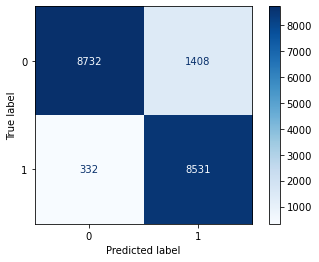

In [107]:
from locale import normalize
from sklearn.metrics import plot_confusion_matrix
class_names = ['0', '1']
plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)


c:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


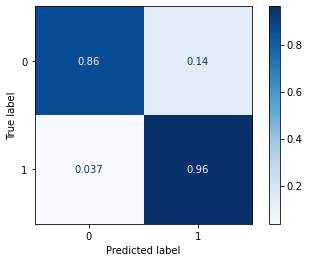

In [108]:
# Plot Bilangan Desimal
class_names = ['0', '1']
plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, normalize='true', cmap=plt.cm.Blues)

### Visualisasi

In [70]:
df.describe()

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
count,76009.000000,7.600900e+04,76009.000000,7.600900e+04,7.600900e+04,76009.000000,76009.000000,76009.000000,7.600900e+04,76009.000000,76009.000000,7.600900e+04,7.600900e+04,76009.000000,75546.000000,75546.000000,76009.000000
mean,69660.272849,4.965191e+07,268.467681,4.680808e+08,2.688867e+11,5.261614,6000.221605,8752.328580,6.473490e+06,291.322383,0.557342,8.863731e+07,8.867216e+07,1131.385441,1138.392860,2276.712242,0.467379
std,48794.473138,4.964958e+07,206.295926,2.727949e+08,2.062462e+11,2.793400,5803.071611,7387.623767,8.190890e+06,246.186503,0.496704,1.585055e+08,1.349843e+08,2650.543596,2219.658397,3336.208544,0.498938
min,9.000000,8.820000e+02,0.000000,0.000000e+00,0.000000e+00,2.000000,4.000000,-130933.000000,-1.464426e+08,-4365.000000,0.000000,2.527000e+03,8.560000e+02,0.000000,0.000000,0.000000,0.000000
25%,29515.000000,3.957162e+06,130.000000,2.530000e+08,1.310000e+11,3.000000,1943.000000,7677.000000,4.935220e+05,255.000000,0.000000,4.272000e+03,3.413000e+03,0.000000,0.000000,0.000000,0.000000
50%,68299.000000,3.330440e+07,230.000000,4.320000e+08,2.310000e+11,5.000000,3421.000000,9232.000000,8.220338e+06,307.000000,1.000000,2.624610e+06,9.192821e+06,0.000000,0.000000,241.000000,0.000000
75%,106134.000000,9.360288e+07,339.000000,7.100000e+08,3.400000e+11,7.000000,7916.000000,13421.000000,1.427054e+07,447.000000,1.000000,1.351180e+08,1.439277e+08,301.000000,848.000000,4065.000000,1.000000
max,260006.000000,1.471280e+08,1821.000000,9.990000e+08,1.820000e+12,17.000000,25224.000000,19190.000000,1.495387e+07,639.000000,1.000000,1.269982e+09,9.905962e+08,20580.000000,16577.000000,20580.000000,1.000000


In [109]:
df.label.value_counts()

0    40484
1    35525
Name: label, dtype: int64

c:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

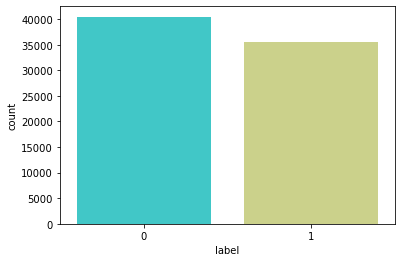

In [72]:
label_dict = dict(df.label.value_counts())
sns.countplot(df.label, palette="rainbow")

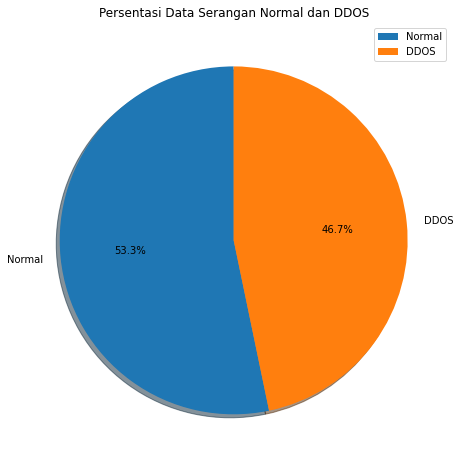

In [27]:
from cgitb import text
from turtle import color


labels = ["Normal", "DDOS"]
sizes = [dict(df.label.value_counts())[0], dict(df.label.value_counts())[1]]
plt.figure(figsize = (13,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend(["Normal", "DDOS"])
plt.title('Persentasi Data Serangan Normal dan DDOS')
plt.show()

In [73]:
df.isnull().sum()

switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        463
tot_kbps       463
label            0
dtype: int64

Text(0.5, 1.0, 'Fitur yang Memiliki nilai Null')

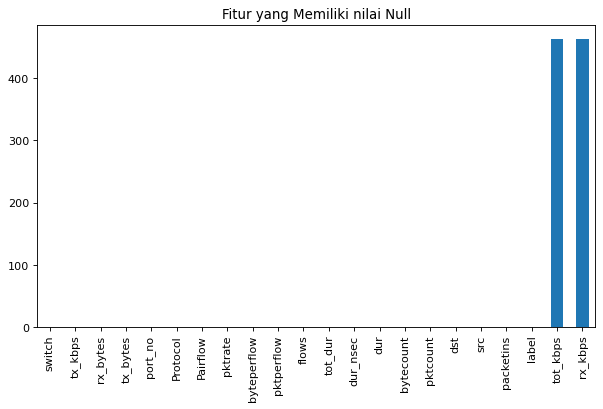

In [29]:
figure(figsize=(9, 5), dpi=80)
df[df.columns[df.isna().sum() >= 0]].isna().sum().sort_values().plot.bar()
plt.title("Fitur yang Memiliki nilai Null")

Text(0.5, 1.0, 'Jumlah Semua Permintaan')

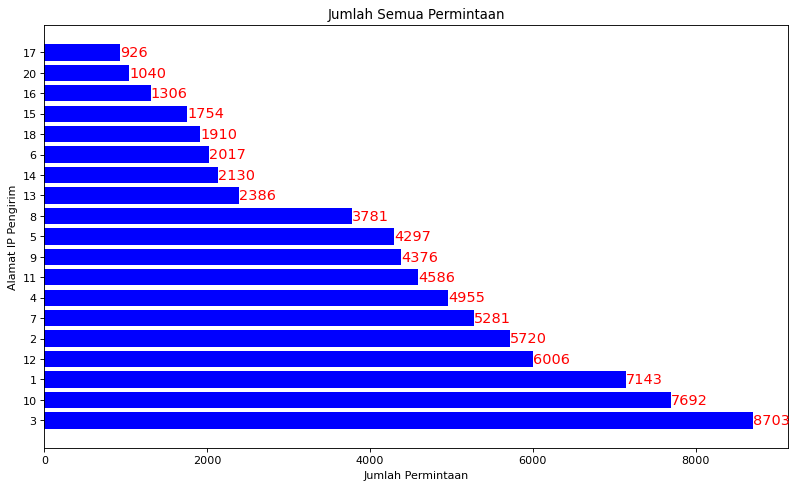

In [30]:
figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(df.src.value_counts()).keys()), dict(df.src.value_counts()).values(), color='blue')

for idx, val in enumerate(dict(df.src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

plt.xlabel('Jumlah Permintaan')
plt.ylabel('Alamat IP Pengirim')
plt.title('Jumlah Semua Permintaan')

Text(0.5, 1.0, 'Jumlah Permintaan Serangan')

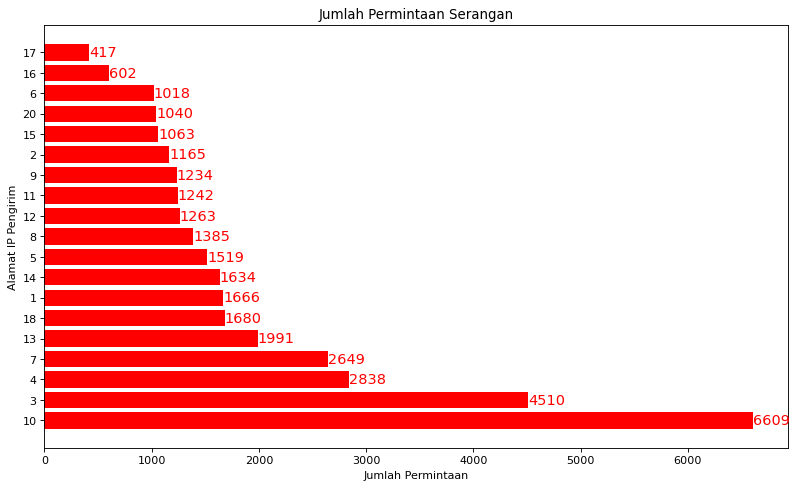

In [31]:
figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(df[df.label == 1].src.value_counts()).keys()), dict(df[df.label == 1].src.value_counts()).values(), color='red')

for idx, val in enumerate(dict(df[df.label == 1].src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

plt.xlabel('Jumlah Permintaan')
plt.ylabel('Alamat IP Pengirim')
plt.title('Jumlah Permintaan Serangan')

Text(0.5, 1.0, 'Jumlah permintaan dari alamat IP yang berbeda')

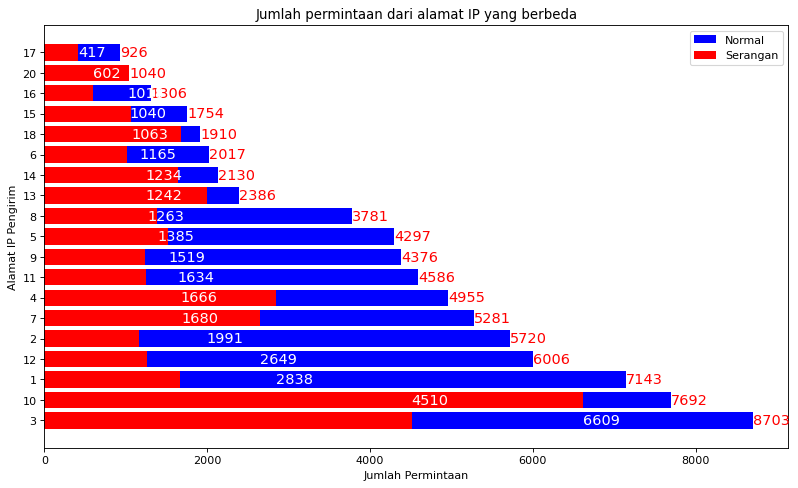

In [32]:
figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(df.src.value_counts()).keys()), dict(df.src.value_counts()).values(), color='blue')
plt.barh(list(dict(df[df.label == 1].src.value_counts()).keys()), dict(df[df.label == 1].src.value_counts()).values(), color='red')

for idx, val in enumerate(dict(df.src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

for idx, val in enumerate(dict(df[df.label == 1].src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='w', size = 13)


plt.xlabel('Jumlah Permintaan')
plt.ylabel('Alamat IP Pengirim')
plt.legend(['Normal','Serangan'])
plt.title('Jumlah permintaan dari alamat IP yang berbeda')

In [33]:
df.Protocol.value_counts()

UDP     31190
TCP     27527
ICMP    17292
Name: Protocol, dtype: int64

c:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Protocol', ylabel='count'>

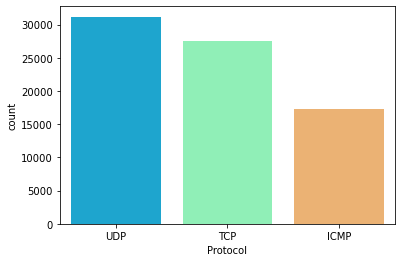

In [34]:
sns.countplot(df.Protocol, palette="rainbow")

In [35]:
df[df.label == 1].Protocol.value_counts()

UDP     15339
TCP     12474
ICMP     7712
Name: Protocol, dtype: int64

c:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Protocol', ylabel='count'>

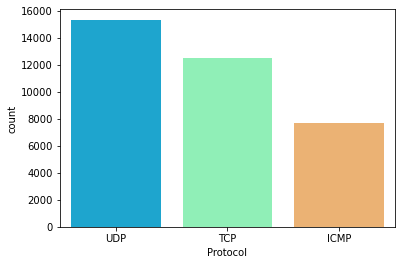

In [36]:
sns.countplot(df[df.label == 1].Protocol, palette="rainbow")

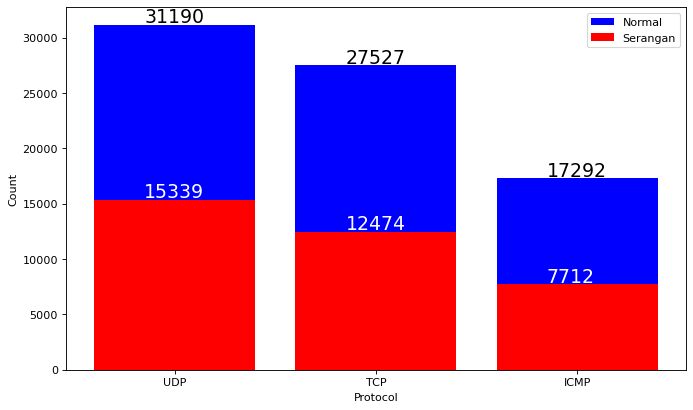

In [37]:
figure(figsize=(10, 6), dpi=80)
plt.bar(list(dict(df.Protocol.value_counts()).keys()), dict(df.Protocol.value_counts()).values(), color='b')
plt.bar(list(dict(df[df.label == 1].Protocol.value_counts()).keys()), dict(df[df.label == 1].Protocol.value_counts()).values(), color='r')

plt.text(x = 0 - 0.15, y = 31190 + 200, s = str(31190), color='black', size=17)
plt.text(x = 1 - 0.15, y = 27527 + 200, s = str(27527), color='black', size=17)
plt.text(x = 2 - 0.15, y = 17292 + 200, s = str(17292), color='black', size=17)

plt.text(x = 0 - 0.15, y = 15339 + 200, s = str(15339), color='w', size=17)
plt.text(x = 1 - 0.15, y = 12474 + 200, s = str(12474), color='w', size=17)
plt.text(x = 2 - 0.15, y = 7712 + 200, s = str(7712), color='w', size=17)

plt.xlabel('Protocol')
plt.ylabel('Count')
plt.legend(['Normal', 'Serangan'])
plt.title('Jumlah permintaan dari protokol yang berbeda')

c:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='switch', ylabel='count'>

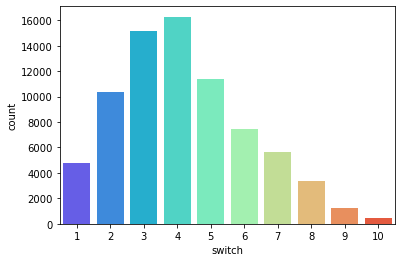

In [38]:
sns.countplot(df.switch, palette="rainbow")